In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
from tqdm.notebook import tqdm

In [2]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate it's vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

## Actor-Critic Model

In [3]:
class PlaceCell(object):
        """
        This class represents one place cell
        """
        
        def __init__(self, center=np.array([0,0]), field_breadth=16):
            """
            - center is the position of the center of this place cell
            
            - field_breadth is the area around the center for which this place cell fires. We
            default this to 16cm since that is what is used in the Morris (2000) paper
            """
            
            self.center = center
            self.field_breadth = field_breadth
            
        def activity_for_position(self, position = np.array([0,0])):
            """
            Calculates the activity given the position for this particular place cell.
            """
            return np.exp(-(np.linalg.norm(position - self.center)**2)/(2*(self.field_breadth**2)))

class PlaceCellPopulation(object):
    """
    This class maintains a population of place cells for a given environment
    """
            
    
    def __init__(self, population_num=493, env_radius=60, field_breadth=16):
        """
        - population_num is the number of place cells
        - env_radius is the radius of the environment in which these place cells will be placed
        - field_breadth is the breadth of the field that each place cell will have
        """
        self.population_num = population_num
        self.env_radius = env_radius
        self.field_breadth = field_breadth
        
        self.place_cells_population = self.initPopulation(self.env_radius, self.field_breadth)
        
    def initPopulation(self, env_radius, field_breadth):
        """
        Initializes a population of place cells based on the population number centered uniformly in the environment
        
        Returns a list of place cell objects.
        
        - env_radius is the radius of the environment centered at 0,0 in which the population is being initialized
        """
        # generate uniformly distributed vectors from the center of the environment to point to a position
        
        # First generate lengths of the vectors away from center at which place cells could be placed
        position_vector_length = np.random.uniform(0, env_radius, self.population_num)
        
        # Generate the angle at which the position vector is pointing at uniformly between 0 radians and 2pi radians
        position_vector_angles = np.random.uniform(0, 2*np.pi, self.population_num)
        
        # Zip vector lengths and angles to generate a list of (length, angle)
        position_vectors = zip(position_vector_length, position_vector_angles)
        
        #Create and return list of place cell objects centered at the uniformly distributed positions
        return [PlaceCell(norm * np.array([math.cos(angle), math.sin(angle)]), field_breadth=field_breadth) for (norm,angle) in position_vectors]
        
    
    def activities_for_position(self, position = np.array([0,0])):
        """
        Returns a list of the activities for all the place cells for a given position
        """
        
        return np.array([placeCell.activity_for_position(position) for placeCell in self.place_cells_population])

In [4]:
class Actor(object):
    """
    This class contains the actor logic of a model
    """
    
    def __init__(self, num_place_cells, directions=8, learning_parameter=0.9):
        """
        - num_place_cells is then number of place cells from which the actor must decide its next move
        - directions is the number of different directions an agent can move in
        - learning_parameter is the coefficient by which the weight updates are multiplied
        """
        
        # Initialize parameters
        self.directions = directions
        self.learning_parameter = learning_parameter
        
        # Initialize weights
        self.weights = np.zeros((self.directions, num_place_cells))
        
    def action_from_policy(self, place_cell_activations):
        """
        Chooses an action based on its policy, which is dependent on the place cell activations
        - place_cell_activations is the array containing the activation pattern of the place cells
        """
        # Calculate the activities of the action cells for the given place cell activation
        action_cell_activities = np.dot(self.weights, place_cell_activations)
        #print('ACTIVITIES', action_cell_activities)
        
        # Calculate the action probabilities
        
        # Important to substract the max if not then we get overflows
        max_activity = np.amax(action_cell_activities)
        action_probabilities = np.exp(2* (action_cell_activities - max_activity)) / np.sum(np.exp(2 * (action_cell_activities - max_activity)))
        #print('ACTION PROBABILITIES',action_probabilities)
        #print('PROBABILITIES_SUM', np.sum(action_probabilities))
        
        # Sample from the action distribution to return the action
        return np.random.choice(self.directions, p=action_probabilities)
        
    def update_weights(self, action, prediction_error, place_cell_activations):
        """
        Updates the weights after an action was done
        - action is the action that was chosen and leads to this weight update
        - prediction_error is the prediction error as calculated by the critic
        - place_cell_activations is the array containing the activation pattern of the place cells
        """
        
        # Calculate the change in weight
        delta_weight = (prediction_error * self.learning_parameter * place_cell_activations)
        # Update just the weights for the action that was taken
        self.weights[action,:] += delta_weight

In [5]:
class Critic(object):
    """
    This class contains the critic logic of a model
    """
    
    def __init__(self, num_place_cells, gamma=0.9, learning_parameter=0.9):
        """
        - num_place_cells is the number of place cells from which the critic must estimate the value of where it is
        - gamma is the discount factor in the calculation of the error prediction
        - learning_parameter is the coefficient by which the weight updates are multiplied
        """
        # Initialize the hyperparameters
        self.gamma = gamma
        self.learning_parameter = learning_parameter
        
        # Initialize weights
        self.weights = np.zeros(num_place_cells)
        
    def compute_prediction_error(self, previous_activations, reward, current_activations):
        """
        Computes the prediction error delta_t
        - previous_activations is the array of place cell activations before the move, so at time t
        - reward is the reward the agent got after making the move at time t
        - current_activations is the array of place cell activations after the move, so at time t+1
        """
        def output(activations):
            return np.dot(self.weights, activations)
        #print('outputs; reward', reward, 'current: ', output(current_activations), 'previous: ', output(previous_activations))
        
        if reward == 1:
            return reward - output(previous_activations)
        else:
            return (self.gamma * output(current_activations)) - output(previous_activations)
        #return reward + (self.gamma * output(current_activations)) - output(previous_activations)
        
        
    def update_weights(self, previous_activations, reward, current_activations):
        """
        To update the critic's weights based on the place cell activation pattern
        - previous_activations is the array of place cell activations before the move, so at time t
        - reward is the reward the agent got after making the move at time t
        - current_activations is the array of place cell activations after the move, so at time t+1
        
        returns the prediction error
        """
        prediction_error = self.compute_prediction_error(previous_activations, reward, current_activations)
        #print('delta wi', np.amax(self.learning_parameter * prediction_error * previous_activations), 'prediction error', prediction_error)
        #print('SHAPE OF UPDATE', np.shape(self.learning_parameter * prediction_error * previous_activations), np.shape(self.weights))
        self.weights += (self.learning_parameter * prediction_error * previous_activations)
        
        return prediction_error

In [6]:
class ActorCriticModel(object):
    """
    This class puts everything together in order to maintain a model that can provide new actions and learn from them
    """
    
    def __init__(
        self, num_place_cells=493, env_radius=60, discount_factor=0.9, 
        actor_learning_rate=0.9, critic_learning_rate=0.9, field_breadth=16
    ):
        """
        Initialize the 3 components of the actor critic model
        """
        
        self.placeCells = PlaceCellPopulation(population_num=num_place_cells, env_radius=env_radius, field_breadth=field_breadth)
        self.critic = Critic(num_place_cells, gamma=discount_factor, learning_parameter=critic_learning_rate)
        self.actor = Actor(num_place_cells, learning_parameter=actor_learning_rate)
        self.last_action_taken = None
        
    def choseAction(self, position):
        """
        Choses the next action based on the position of the agent
        - position is the np.array which represents the position of the agent currently
        
        Returns the action chosen by the model's policy
        """
        
        place_cell_activations = self.placeCells.activities_for_position(position)
        
        action_chosen = self.actor.action_from_policy(place_cell_activations)
        self.last_action_taken = action_chosen
        return action_chosen
    
    def update_weights(self, previous_position, reward, current_position):
        """
        To update the model's weights based on the place cell activation pattern
        - previous_position is the position before the move, so p_t
        - reward is the reward the agent got after making the move at time t
        - current_position is the position after the move, so p_t+1
        """
        previous_activations = self.placeCells.activities_for_position(previous_position)
        current_activations = self.placeCells.activities_for_position(current_position)
        
        prediction_error = self.critic.update_weights(previous_activations, reward, current_activations)
        self.actor.update_weights(self.last_action_taken, prediction_error, previous_activations)
        
        

## Experiment
> For N=493 with radius 60cm we have that a learning parameter rate of 0.05 for both critic and actor is best

If we reduce the number of place cells to 295 so that the density of place cells in the environment is the same as in the paper (where they use 493 place cells for a radius of 100cm) in order to use a 60cm radius instead

if we reduce the number of place cells to 147 keeping the breadth to 16cm, we get pretty good results with learning parameters of 0.2 and 0.2

If we also make the breadth smaller for the environment (in the paper they use 16cm for a 100cm radius of environment), say 10, WE GET good results with 0.3 0.3 as learning rates for actor and critic respectively

When the learning rate is too high, we end up always bouncing off one particular section of the wall given a starting position. This seems to be happening because very quickly our move probabilities tend a single move, rather than still allowing exploration

0.1 for critic and 0.5 for actor works very well, and 0.1 and 0.6 even better it seems

In [42]:
class WatermazeExperiment(object):
    
    """
    This class takes care of coordinating the experiment and produce the plots as shown in the Morris (2000) paper.
    """
    
    def __init__(self, num_days=7, num_trials_per_day=4, model=ActorCriticModel()):
        
        """
        The init function for the experiment module.
        
        - num_trials_per_day is the number of trials we are doing per day.
        - num_days is over how many days we are conducting the experiment.
        - model is the model which is driving the agent's movements and learning
        """
        
        self.num_trials_per_day = num_trials_per_day
        self.num_days = num_days
        self.model = model
        
        """
        Data structures to hold the information of the different runs
        """
        # Holds the watermaze objects for a run. Allows access of the watermaze for a given [day][trialNumber]
        self.exp_mazes = [[0 for trials in range(self.num_trials_per_day)] for days in range(self.num_days)]
    
    def run(self):
        """
        Runs the experiment.
        """
        for day in range(self.num_days):
            for trial in range(self.num_trials_per_day):
                maze = watermaze()
                
                # Store the maze for future reference
                self.exp_mazes[day][trial] = maze
                
                self.runMaze(maze)
        pass
    
    def runMaze(self, maze):
        maze.startposition()
        
        while(not maze.timeup() and not maze.atgoal()):
            
            #Select action
            position_before = maze.position[:, maze.t]
            A = self.model.choseAction(position_before)
            
            #move in the maze
            maze.move(A)
            
            #learn from this move
            position_after = maze.position[:, maze.t]
            reward = 1 if maze.atgoal() else 0
            self.model.update_weights(position_before, reward, position_after)
    
    def plotPaths(self):
        """
        Plots the paths of all of the runs in the experiment
        """
        for day in range(self.num_days):
            for trial in range(self.num_trials_per_day):
                
                maze_for_trial = self.exp_mazes[day][trial]
                print('Day:', day, 'Trial:', trial, 'Time:', maze_for_trial.t, 'Success?',maze_for_trial.atgoal())
                maze_for_trial.plotpath()
        
    
    def plotPerformance(self):
        """
        Plots the performance in terms of time taken to get to the goal over the trial days.
        """
        pass
    
    def callForAllTrials(self, func):
        """
        Calls the function func sent in the argument for each trial in the experiment
        
        - func: function to be called in the form of func(day, trial)
        """

## Find the best learning rates
The paper mentions that the learning rate parameters were optimized for both the actor and the critic. It also does not mention a value for the discount factor gamma, but we set the gamma value to 0.9 and only optimize on the learning rates.

Since various configurations can have a lot of variance especially at the beginning, and because the origin of the task heavily impacts how long it takes to get to the goal, it's important to take an average over the times the experiments take for a given configuration.

In [47]:
class ActorCriticOptimizer(object):
    """
    Optimizes the hyperparameters of a model by trying different combinations of them over a number of trials.
    """
    
    def __init__(self, gamma_values=[0.9], actor_learning_rates=[0.9], critic_learning_rates=[0.9] , trials_per_config=5):
        """
        Initializes the Optimization Class
        - gamma_values are the gamma/discount factor values we want to optimize over
        - actor_learning_rates are the actor learning rates we want to optimize over
        - critic_learning_rates are the critic learning rates we want to optimize over
        
        - trials_per_config is the number of trials to do per config, and then average the trial performances
        """
        self.gamma_values = gamma_values
        self.actor_learning_rates = actor_learning_rates
        self.critic_learning_rates = critic_learning_rates
        self.trials_per_config = trials_per_config
        
    def optimize(self):
        # Stores the most performant configuration as a tuple ((gamma, actor_rate, critic_rate), avg_sum_of_time)
        best_config= (None, float('inf'))
        
        for gamma in tqdm(self.gamma_values, desc='discount factor'):
            for actor_rate in tqdm(self.actor_learning_rates, desc='actor learning rate', leave=False):
                for critic_rate in tqdm(self.critic_learning_rates, desc='critic learning rate', leave=False):
                    
                    #The sum of the sum of times taken during an experiment
                    experiment_time_sum_over_trials = 0
                    
                    for trial in range(self.trials_per_config):
                        experiment = WatermazeExperiment(7,4, ActorCriticModel(discount_factor=gamma, actor_learning_rate=actor_rate, critic_learning_rate=critic_rate, field_breadth=10))
                        experiment.run()
                        
                        #calculate the sum of the times taken for the agent to arrive at the goal
                        trials_flattened = [j for sub in experiment.exp_mazes for j in sub]
                        experiment_time_sum_over_trials += np.array([maze.t for maze in trials_flattened]).sum()
                    
                    avg_sum_of_experiment_time = experiment_time_sum_over_trials / self.trials_per_config
                    if avg_sum_of_experiment_time < best_config[1]:
                        best_config = ((gamma, actor_rate, critic_rate), avg_sum_of_experiment_time)
                        
                        
        print("The optimal configuration was found to be ", best_config)
        
        
optimizer = ActorCriticOptimizer(actor_learning_rates=np.arange(0.2,0.7,0.1), critic_learning_rates=np.arange(0.04,0.1,0.02), trials_per_config=3)
optimizer.optimize()
                        
                        
            
        
        

discount factor:   0%|          | 0/1 [00:00<?, ?it/s]

actor learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

critic learning rate:   0%|          | 0/4 [00:00<?, ?it/s]

critic learning rate:   0%|          | 0/4 [00:00<?, ?it/s]

critic learning rate:   0%|          | 0/4 [00:00<?, ?it/s]

critic learning rate:   0%|          | 0/4 [00:00<?, ?it/s]

critic learning rate:   0%|          | 0/4 [00:00<?, ?it/s]

The optimal configuration was found to be  ((0.9, 0.5000000000000001, 0.1), 697.3333333333334)


Day: 0 Trial: 0 Time: 13 Success? True


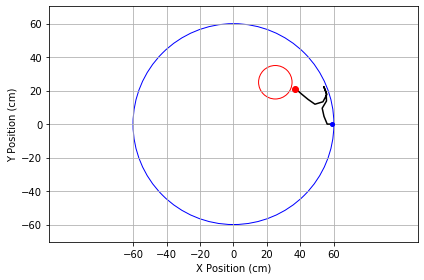

Day: 0 Trial: 1 Time: 10 Success? True


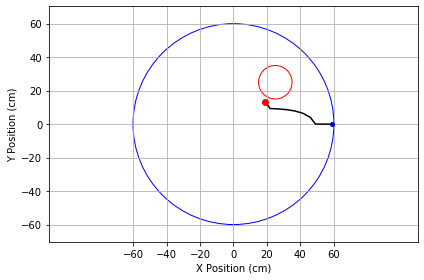

Day: 0 Trial: 2 Time: 59 Success? False


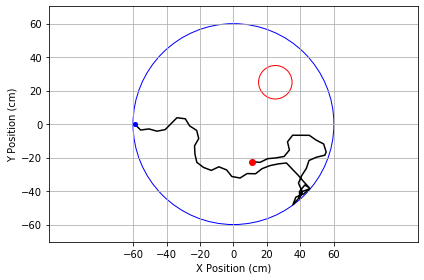

Day: 0 Trial: 3 Time: 23 Success? True


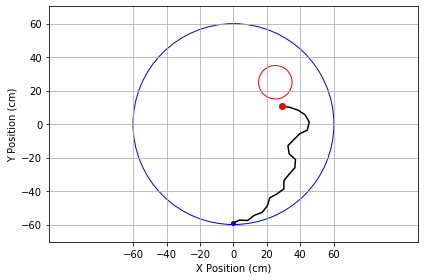

Day: 1 Trial: 0 Time: 40 Success? True


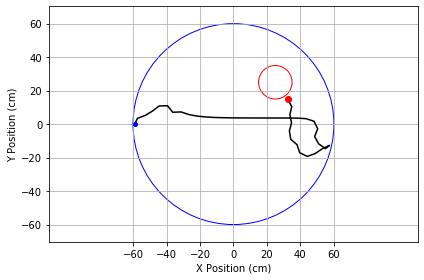

Day: 1 Trial: 1 Time: 32 Success? True


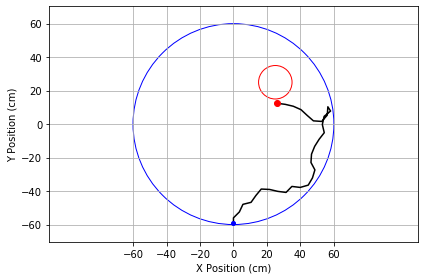

Day: 1 Trial: 2 Time: 40 Success? True


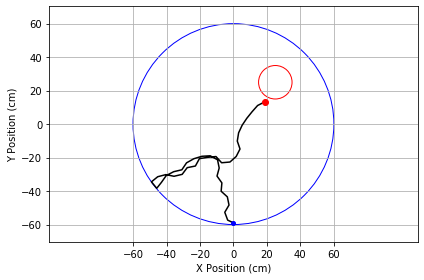

Day: 1 Trial: 3 Time: 8 Success? True


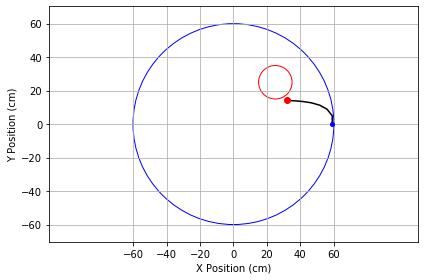

Day: 2 Trial: 0 Time: 9 Success? True


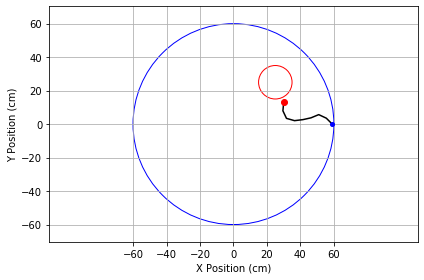

Day: 2 Trial: 1 Time: 13 Success? True


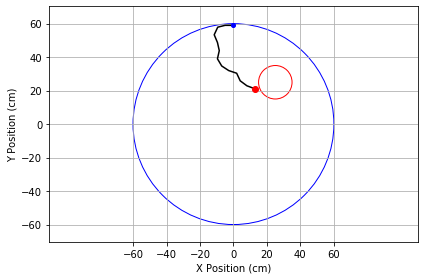

Day: 2 Trial: 2 Time: 12 Success? True


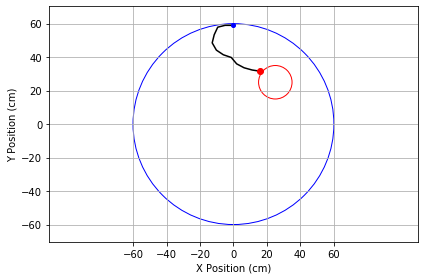

Day: 2 Trial: 3 Time: 9 Success? True


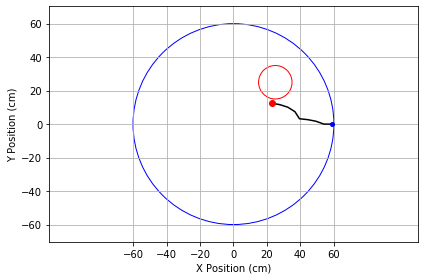

Day: 3 Trial: 0 Time: 29 Success? True


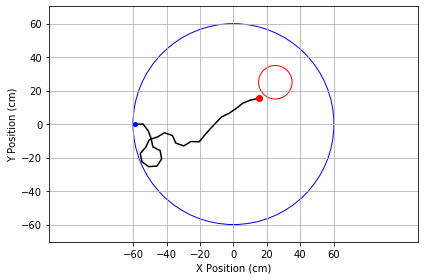

Day: 3 Trial: 1 Time: 24 Success? True


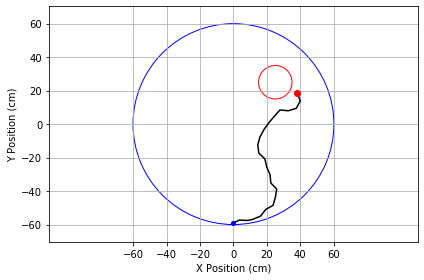

Day: 3 Trial: 2 Time: 14 Success? True


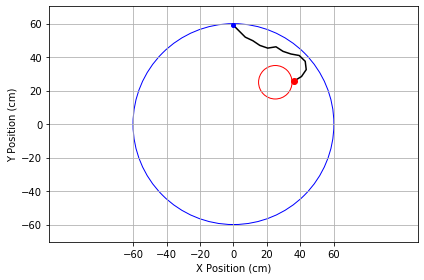

Day: 3 Trial: 3 Time: 20 Success? True


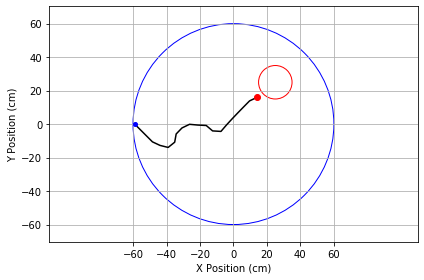

Day: 4 Trial: 0 Time: 8 Success? True


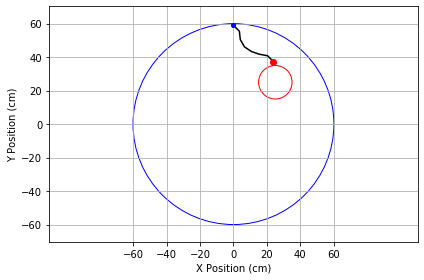

Day: 4 Trial: 1 Time: 21 Success? True


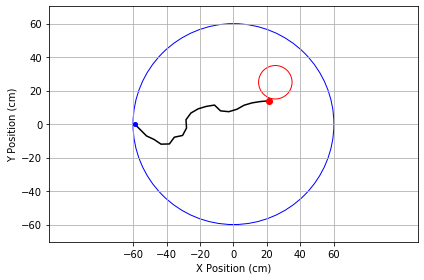

Day: 4 Trial: 2 Time: 19 Success? True


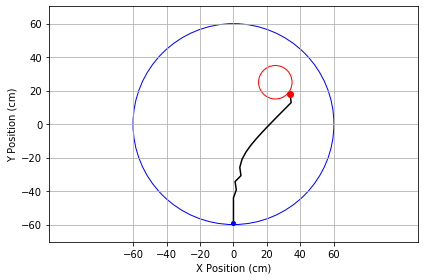

Day: 4 Trial: 3 Time: 25 Success? True


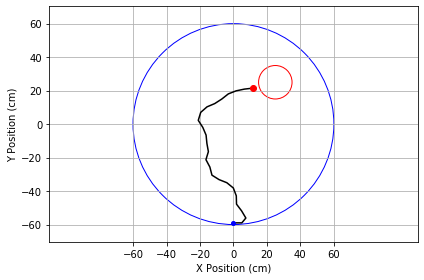

Day: 5 Trial: 0 Time: 17 Success? True


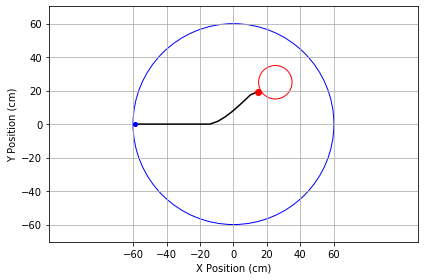

Day: 5 Trial: 1 Time: 28 Success? True


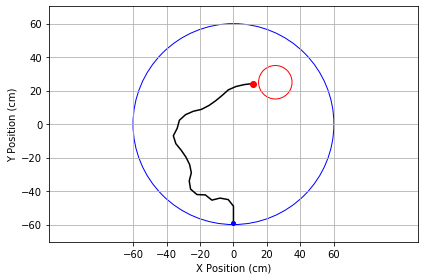

Day: 5 Trial: 2 Time: 20 Success? True


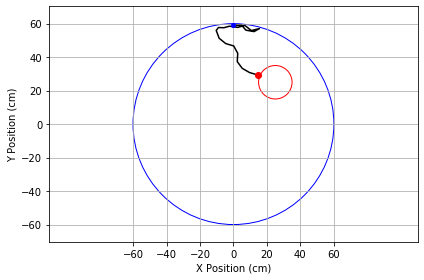

Day: 5 Trial: 3 Time: 17 Success? True


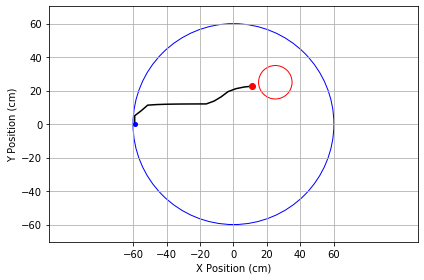

Day: 6 Trial: 0 Time: 8 Success? True


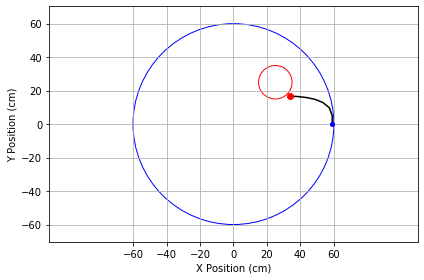

Day: 6 Trial: 1 Time: 33 Success? True


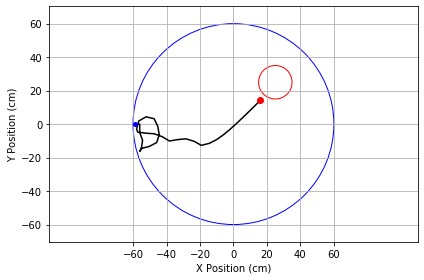

Day: 6 Trial: 2 Time: 9 Success? True


Exception ignored in: <function tqdm.__del__ at 0x000002490ABC4B88>
Traceback (most recent call last):
  File "C:\Users\obiaf\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\obiaf\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


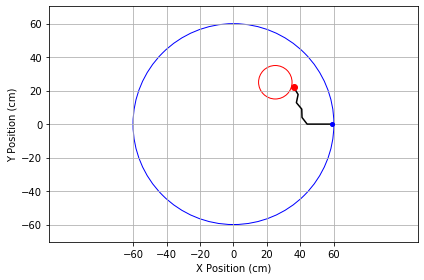

Day: 6 Trial: 3 Time: 14 Success? True


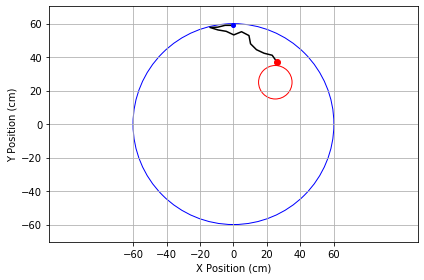

In [48]:
experiment = WatermazeExperiment(7,4,ActorCriticModel(num_place_cells=493,actor_learning_rate=0.5, critic_learning_rate=0.1, field_breadth=10))
#experiment = WatermazeExperiment(10,4,ActorCriticModel(num_place_cells=493,actor_learning_rate=0.6, critic_learning_rate=0.1, field_breadth=16))
experiment.run()
experiment.plotPaths()

## Performance on the RMW task using the optimal learning rates found above

In [46]:
def calculate_escape_latencies(
    gen_model=lambda : ActorCriticModel(actor_learning_rate=0.6, critic_learning_rate=0.1, field_breadth=10), 
    iterations=20
):
    """
    Returns the mean and standard deviation of the escape latencies in the experiment's trials
    - gen_model is a function that returns a model to be used in each iteration
    - iteration is the number of times the experiment should be repeated
    """
    iteration_results = []
    for iteration in tqdm(range(iterations), desc="Iteration", leave=False):
        experiment = WatermazeExperiment(model=gen_model())
        experiment.run()
        
        # We obtain a list of the mazes for the different trials
        trials_in_exp_flattened = [j for sub in experiment.exp_mazes for j in sub]
        
        #Add it to our iteration results
        iteration_results.append(trials_in_exp_flattened)
        
    # Now we zip each corresponding trial from the different iterations together
    iteration_results_by_trial = list(zip(*iteration_results))
    
    escape_latencies_by_trial = [[maze.t for maze in exp_iterations_for_trial] for exp_iterations_for_trial in iteration_results_by_trial]
    
    mean_latencies_by_trial = [np.mean(latencies_in_trial) for latencies_in_trial in escape_latencies_by_trial]
    latency_std_dev_by_trial = [np.std(latencies_in_trial) for latencies_in_trial in escape_latencies_by_trial]
    
    return mean_latencies_by_trial, latency_std_dev_by_trial

def plot_escape_latency_by_trial_plot(mean, std_dev):
     plt.errorbar(np.arange(len(mean)), mean, yerr=std_dev, fmt='.k')
        



Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

([59.0, 44.333333333333336, 33.666666666666664, 41.333333333333336, 32.666666666666664, 46.0, 32.666666666666664, 34.0, 29.666666666666668, 25.333333333333332, 19.0, 15.0, 22.0, 22.0, 20.666666666666668, 12.333333333333334, 19.666666666666668, 28.0, 33.333333333333336, 17.666666666666668, 18.666666666666668, 18.0, 18.0, 16.333333333333332, 37.0, 24.333333333333332, 18.0, 18.666666666666668], [0.0, 20.741798914805393, 20.038851153585515, 19.601587237318874, 20.499322482029065, 18.384776310850235, 20.8539897594894, 19.30457631409368, 16.35712552851373, 10.873004286866726, 8.48528137423857, 3.7416573867739413, 2.943920288775949, 1.632993161855452, 7.93025150224688, 4.189935029992178, 7.760297817881877, 6.377042156569663, 18.190351532856337, 5.557777333511022, 4.496912521077347, 2.943920288775949, 3.265986323710904, 7.039570693980958, 16.30950643030009, 4.988876515698588, 9.41629792788369, 3.299831645537222])


## The Coordinate Learner

In [ ]:
class CoordinateModel(object):
    """
    This model takes care of learning a global coordinate system based on the place cell activities.
    """
    
    def __init__(self, num_place_cells=493, trace_lambda=0.9, max_time=60):
        """
        - num_place_cells is the number of place cells this coordinate model will be dealing with
        - trace_lambda is the coeffecient which dictates to what extent more distant timesteps are considered
        """
        self.num_place_cells = num_place_cells
        self.trace_lambda = distance_lambda
        
        #Initialize the variable that will keep track of the last goal coordinate as learned by the model
        self.goal_coordinate_memory = None
        
        # The weights for the x and y coordinates
        self.x_weights = np.zeros((1,num_place_cells))
        self.y_weights = np.zeros((1,num_place_cells))
        
        # Running sum of the place cell activations at different times adjusted using the distance_lambda
        self.place_cell_trace = 0;
        
    def update_weights(self, place_cell_activities):
        """
        - place_cell_activities is a vector of the place cell activities for which we want to calculate the output for
        """
        # updates the trace, basically implements the summation in equations 11 and 12 of the paper but in a running fashion
        self.place_cell_trace = self.place_cell_trace * self.trace_lambda + place_cell_activities
        
        delta_x_weights = 
        
        
    def chooseAction(self, place_cell_activities):
        """
        Chooses the action dictated by its goal memory
        
        - place_cell_activities is a vector of the place cell activities for which we want to calculate the output for
        """
        pass
        
    def memorize_goal(self, place_cell_activities):
        """
        Enters a goal into memory by using the place cell activities to generate the position for it
        - place_cell_activities is a vector of the place cell activities for which we want to calculate the output for
        """
        pass
        
        

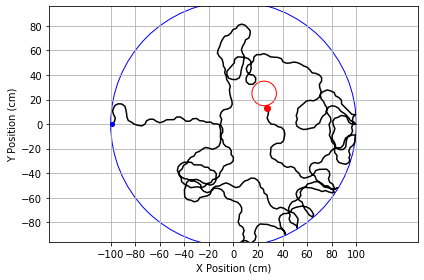

Clever rat, you found the platform in 575 seconds!


In [252]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze(pool_radius=100, T=1200, stepsize=3, momentum=0.33)

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in",maze.t,"seconds!")
else:
    print("No more time for you dumb-dumb...")

Sometimes it seems like we get really close to the goal but then dont acually say we're there:
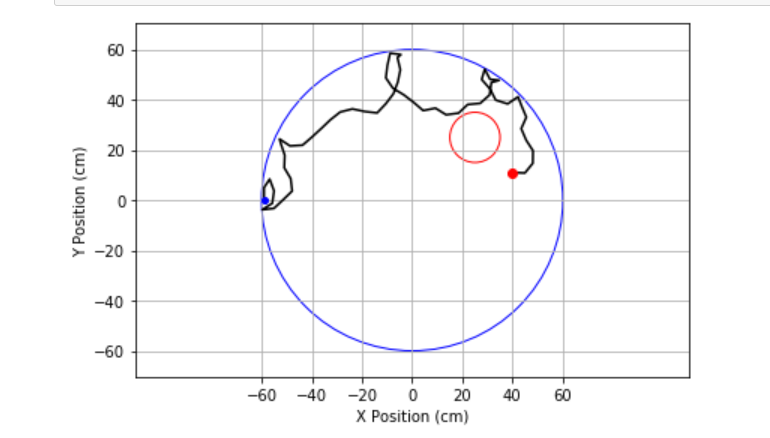